In [2]:
temp1_cache = {}
temp_cache = {}
length = 50

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import fredapi
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_squared_error
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import joblib
import os


In [4]:
def datasets(company_name, date_start):
    cache_key = (company_name, date_start)
    if cache_key in temp1_cache:
        return temp1_cache[cache_key]

    df_tesla = yf.download(company_name, start=date_start)
    df_tesla = df_tesla.reset_index().rename(columns={"index": "Date"})

    API_KEY = "d78d2aa2f6988647712d6761315c3a62"  # Replace with your actual API key
    fred = fredapi.Fred(api_key=API_KEY)

    # Get economic data
    gdp_data = fred.get_series("GDP")
    cpi_data = fred.get_series("CPIAUCSL")
    unemployment_data = fred.get_series("UNRATE")
    fed_funds_data = fred.get_series("FEDFUNDS")
    sp500_data = fred.get_series("SP500")
    vix_data = fred.get_series("VIXCLS")

    df_economic = pd.DataFrame({
        "SP500": sp500_data,
        "VIX": vix_data,
        "GDP": gdp_data,
        "CPI": cpi_data,
        "UR": unemployment_data,
        "FF": fed_funds_data})
    df_economic = df_economic.reset_index().rename(columns={"index": "Date"})
    df_economic = df_economic[df_economic['Date'] > date_start]

    df_tesla1 = df_tesla.copy()
    df_tesla1.columns = df_tesla.columns.droplevel(1)
    df_merged = pd.merge(df_tesla1, df_economic, on='Date', how='left')

    numeric_cols = df_merged.columns.drop('Date')
    df_merged[numeric_cols] = df_merged[numeric_cols].astype('float64')

    # Imputation
    numeric_data = df_merged.drop(columns=['Date'])
    imputer = KNNImputer(n_neighbors=2)
    df_merged_imputed = pd.DataFrame(imputer.fit_transform(
        numeric_data), columns=numeric_data.columns)
    df_merged.iloc[:, 1:] = df_merged_imputed

    # LSTM model preparation
    df_merged = df_merged.drop(columns=['High', 'Low', 'Open'])
    test_percent = 0.2
    test_point = np.round(len(df_merged) * test_percent)
    test_index = int(len(df_merged) - test_point)

    train = df_merged.iloc[:test_index]
    test = df_merged.iloc[test_index:]

    # 1. Remove 'Date' column
    train_no_date = train.drop(columns='Date')
    test_no_date = test.drop(columns='Date')

    X_train, y_train = train_no_date.drop(
        columns='Close'), train_no_date['Close']
    X_test, y_test = test_no_date.drop(columns='Close'), test_no_date['Close']

    # 3. Create separate scalers
    scaler_y = MinMaxScaler()
    scaler_merged = MinMaxScaler()

    scaled_merged_train = pd.DataFrame(scaler_merged.fit_transform(
        train_no_date), columns=train_no_date.columns, index=train_no_date.index)
    scaled_merged_test = pd.DataFrame(scaler_merged.transform(
        test_no_date), columns=test_no_date.columns, index=test_no_date.index)

    scaled_y_train = pd.Series(scaler_y.fit_transform(
        y_train.values.reshape(-1, 1)).flatten(), index=y_train.index, name='Close')
    scaled_y_test = pd.Series(scaler_y.transform(
        y_test.values.reshape(-1, 1)).flatten(), index=y_test.index, name='Close')
    X_train_array = scaled_merged_train.to_numpy()
    y_train_array = scaled_merged_train['Close'].to_numpy().reshape(-1, 1)

    scaled_y_test = scaled_y_test.reset_index(drop=True)
    X_test_array = scaled_merged_test.to_numpy()
    y_test_array = scaled_merged_test['Close'].to_numpy().reshape(-1, 1)

    temp1_cache[cache_key] = (X_train_array, scaled_y_train, X_test_array,
                              scaled_y_test, scaled_merged_train, scaler_y, scaler_merged, df_merged)
    return temp1_cache[cache_key]

In [5]:
def model_building(companies, date_start):

    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)

    for name in companies:
        X_train_array, scaled_y_train,X_test_array,scaled_y_test,scaled_merged_train,scaler_y,scaler_merged, df_merged = datasets(name, date_start)
        train_generator = TimeseriesGenerator(X_train_array,scaled_y_train, length = length, batch_size =1)
        test_generator = TimeseriesGenerator(X_test_array,scaled_y_test, length = length, batch_size =1)
        model = Sequential()

        model.add(keras.Input(shape = (length,scaled_merged_train.shape[-1])))
        model.add(LSTM(50))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mse')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(train_generator, epochs=100, validation_data=test_generator, callbacks=[early_stopping])
        model_path = os.path.join(model_dir, f"{name}_model.pkl")
        joblib.dump(model, model_path)


    return

In [6]:
def prediction(companies, date_start):
    cache_key = tuple(companies) + (date_start,)
    if cache_key in temp_cache:
        return temp_cache[cache_key]

    loaded_models = {}
    predictions_dict = {}

    for name in companies:
        # Check if predictions for this company are already cached
        individual_cache_key = (name, date_start)
        model_path = os.path.join("models", f"{name}_model.pkl")
        if individual_cache_key in temp1_cache:
            # Reuse cached data and skip model loading and prediction
            _, _, X_test_array, scaled_y_test, _, scaler_y, _, _ = temp1_cache[individual_cache_key]


            # Load model if not already loaded
            if name not in loaded_models: #Check if model has been loaded before
                loaded_models[name] = joblib.load(model_path)
                print(f"Loaded model for {name}")

            test_generator = TimeseriesGenerator(X_test_array, scaled_y_test, length=length, batch_size=1)
            predictions_test = loaded_models[name].predict(test_generator, verbose=0) #predict only if necessary
            predictions_original_test = scaler_y.inverse_transform(predictions_test).ravel()
            predictions_dict[name] = predictions_original_test

        else:
            # If not cached, proceed with loading model and generating predictions
            loaded_models[name] = joblib.load(model_path)
            print(f"Loaded model for {name}")

            _, _, X_test_array, scaled_y_test, _, scaler_y, _, _ = datasets(name, date_start)
            test_generator = TimeseriesGenerator(X_test_array, scaled_y_test, length=length, batch_size=1)
            predictions_test = loaded_models[name].predict(test_generator, verbose=0)
            predictions_original_test = scaler_y.inverse_transform(predictions_test).ravel()
            predictions_dict[name] = predictions_original_test

    temp_cache[cache_key] = predictions_dict
    return predictions_dict

In [7]:
def results(companies,date_start):

    df_results = pd.DataFrame()

    for company in companies:

        pred = prediction([company], date_start)
        df_results[company] = pred[company]
        _, _, X_test_array, _, _, _, _, df_merged = datasets(company, date_start)
        test_dates = df_merged['Date'].iloc[-len(X_test_array)+length:]
        df_results.index = test_dates

    return df_results


In [8]:

def predict_future_x_days(model,company_name, date_start, x_days):
    _, _,_,_,_,scaler_y,scaler_merged, df_merged = datasets(company_name, date_start)
    # Przygotowanie pełnych danych - nie usuwamy 'Close' od razu
    df_all_no_date = df_merged.drop(columns='Date')
    scaled_all = pd.DataFrame(scaler_merged.transform(df_all_no_date), columns=df_all_no_date.columns)
    X_all = scaled_all.to_numpy()  # Zachowujemy wszystkie kolumny, w tym 'Close'

    # Ostatnie 50 dni
    last_length_days = X_all[-length:].reshape((1, length, X_all.shape[-1]))  # Shape: (1, 50, 8)
    predictions = []
    current_sequence = last_length_days.copy()

    for _ in range(x_days):
        next_pred = model.predict(current_sequence, verbose=0)
        predictions.append(next_pred[0, 0])
        next_input = current_sequence[0, 1:, :] #usuwa pierwszy element current sequence
        new_row = current_sequence[0, -1, :].copy() #bierze ostatni wiersz current sequence
        new_row[0] = next_pred[0, 0]  # Aktualizujemy 'Close' (pierwsza kolumna)
        current_sequence = np.append(next_input, [new_row], axis=0).reshape((1, length, X_all.shape[-1]))

    predictions_unscaled = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).ravel()
    last_date = pd.to_datetime(df_merged['Date'].iloc[-1])
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=x_days, freq='B')

    return pd.DataFrame({'Date': future_dates, 'Predicted_Close': predictions_unscaled})



def results_future_x_days_all_companies(companies, date_start, x_days):
    df_future_results = pd.DataFrame()
    loaded_models = {}
    for name in companies:
        model_path = os.path.join("models", f"{name}_model.pkl")
        loaded_models[name] = joblib.load(model_path)



    # Pobieramy daty z pierwszej spółki, aby użyć ich jako indeksu (???)
    first_company_predictions = predict_future_x_days(loaded_models[companies[0]],companies[0] ,date_start, x_days)
    df_future_results['Date'] = first_company_predictions['Date']

    # Dodajemy predykcje dla każdej spółki
    for company in companies:
        predictions = predict_future_x_days(loaded_models[company],company, date_start, x_days)
        df_future_results[company] = predictions['Predicted_Close']

    # Ustawiamy 'Date' jako indeks
    df_future_results.set_index('Date', inplace=True)

    return df_future_results


In [9]:
def plot_stock(companies, date_start):
    fig, axes = plt.subplots(nrows=len(companies), ncols=1, figsize=(20, 12))
    predictions = prediction(companies, date_start)

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for i, company in enumerate(companies):
        ax = axes[i]

        _, _, _, _, _, _, _, df = datasets(company, date_start)

        # Get the length of predictions for this company
        pred_len = len(predictions[company])

        # Adjust test_dates to match the length of predictions
        test_dates = df['Date'][-pred_len:]

        ax.plot(df['Date'], df['Close'], color='blue')
        # Use adjusted test_dates for plotting predictions
        ax.plot(test_dates, predictions[company], color='red')
        ax.set_title(f'Stock Price Prediction for {company}')
        ax.set_ylabel('Price', fontsize=14)
        if i == 0:
            ax.legend(['Actual', 'Predicted'])


    axes[-1].set_xlabel('Date', fontsize=14)

    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_stock_with_future(companies, date_start, x_days):
 
    fig, axes = plt.subplots(nrows=len(companies), ncols=1, figsize=(20, 12))
    future_predictions = results_future_x_days_all_companies(companies, date_start, x_days)

    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for i, company in enumerate(companies):
        ax = axes[i]

        # Get necessary data from temp1 (including test data indexes)
        _, _, X_test_array, scaled_y_test, _, scaler_y, _, df = datasets(company, date_start)

        # Extract test dates from the original DataFrame (df)
        test_dates = df['Date'].iloc[-len(X_test_array):]  # Dates after training data

        # Filter data for plotting
        df_test = df[df['Date'].isin(test_dates)]
        future_predictions_test = future_predictions[future_predictions.index.isin(future_predictions.index)]  # Ensures dates align

        # Rescale y_test (if needed - using your existing scaling logic)
        y_test_original = scaler_y.inverse_transform(scaled_y_test.values.reshape(-1, 1)).ravel()


        # Plot only test data
        ax.plot(df_test['Date'], df_test['Close'], color='blue', label='Actual')
        ax.plot(future_predictions_test.index, future_predictions_test[company], color='green', label=f'Future Predictions ({x_days} days)')

        ax.set_title(f'Stock Price Prediction for {company} (Test Data)')
        ax.set_ylabel('Price', fontsize=14)
        if i == 0:
            ax.legend()

    axes[-1].set_xlabel('Date', fontsize=14)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()


<h3> Example usage of every function listed above. All of the functions can be found in Functions folder

<h5> We start with building models for chosen companies

In [11]:
model_building(['TSLA','NVDA','AAPL'],'2017-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 1/100


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1598/1598 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0168 - val_loss: 0.0051
Epoch 2/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0025 - val_loss: 0.0106
Epoch 3/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 4/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0014 - val_loss: 0.0100
Epoch 8/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013 - val_loss: 8.8984e-04
Epoch 11/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013 - val_loss: 9.2688e-04
Epoch 12/100
1598/1598 

[*********************100%***********************]  1 of 1 completed


Epoch 1/100


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1598/1598 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0110 - val_loss: 0.1458
Epoch 2/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0019 - val_loss: 0.0530
Epoch 3/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0015 - val_loss: 0.0626
Epoch 4/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0011 - val_loss: 0.1068
Epoch 5/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013 - val_loss: 0.0976
Epoch 6/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 9.3487e-04 - val_loss: 0.0351
Epoch 7/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.7127e-04 - val_loss: 0.1277
Epoch 8/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.5884e-04 - val_loss: 0.0573
Epoch 9/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.0646e-04 - val_loss: 0.0715
Epoch 10/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.0519e-04 - val_loss: 0.0330
Epoch 11/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.7215e-04 - val_loss: 0.0242
Epoch 1

[*********************100%***********************]  1 of 1 completed


Epoch 1/100


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1598/1598 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0116 - val_loss: 0.0020
Epoch 2/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 3/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 4/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 5/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 6/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 7/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0014 - val_loss: 9.2121e-04
Epoch 8/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 10/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 11/100
1598/1598 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 9.7770e-04 - val_loss: 0.0036
Epoch 12/100
1598/1598 

<h5> Now that 3 models have been created they are saved in models folder and we can start testing our functions

In [12]:
datasets('TSLA','2019-01-01')

[*********************100%***********************]  1 of 1 completed


(array([[0.02196604, 0.16444044, 0.10653105, ..., 0.2233274 , 0.03539823,
         0.22443182],
        [0.02033136, 0.08486253, 0.08224964, ..., 0.51442015, 0.11946903,
         0.47632576],
        [0.02323392, 0.09213465, 0.11509245, ..., 0.40629139, 0.01769912,
         0.6969697 ],
        ...,
        [0.58262848, 0.08316938, 0.92490114, ..., 0.51442015, 0.11946903,
         0.47632576],
        [0.57232799, 0.07744279, 0.93196205, ..., 0.52318031, 0.02654867,
         0.64204545],
        [0.56546934, 0.07452015, 0.94026946, ..., 0.52318031, 0.02654867,
         0.64204545]]),
 0       0.021966
 1       0.020331
 2       0.023234
 3       0.026126
 4       0.026192
           ...   
 1241    0.571398
 1242    0.579614
 1243    0.582628
 1244    0.572328
 1245    0.565469
 Name: Close, Length: 1246, dtype: float64,
 array([[0.57119742, 0.13212062, 0.96503931, ..., 0.46953851, 0.15486726,
         0.48011364],
        [0.60074231, 0.14855922, 0.96990809, ..., 0.40876179, 0.0044247

In [13]:
prediction(['TSLA','NVDA','AAPL'],'2020-01-01')

[*********************100%***********************]  1 of 1 completed

Loaded model for TSLA



c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[*********************100%***********************]  1 of 1 completed

Loaded model for NVDA



c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loaded model for AAPL


[*********************100%***********************]  1 of 1 completed
c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


{'TSLA': array([174.45163, 173.98492, 170.87738, 170.94405, 175.07616, 174.58357,
        178.56323, 178.00223, 178.59389, 181.49557, 182.23994, 177.91899,
        179.25322, 179.34981, 178.44576, 176.54185, 178.8843 , 179.25531,
        178.36487, 178.23685, 179.09155, 179.62595, 177.33437, 174.81944,
        176.69206, 179.78076, 181.62967, 184.63864, 188.2944 , 185.6751 ,
        185.44533, 185.7218 , 188.37448, 194.15564, 198.25047, 198.31648,
        203.94145, 214.72244, 239.26874, 249.06229, 252.68117, 259.65204,
        263.8967 , 245.01022, 245.8152 , 247.30276, 253.46315, 247.54974,
        244.69153, 239.3784 , 242.99582, 244.8276 , 222.93645, 217.49214,
        217.7528 , 223.75633, 220.70677, 228.70712, 218.01677, 204.7618 ,
        188.35576, 194.5494 , 190.22554, 195.74448, 201.16328, 200.72238,
        205.55252, 205.49948, 211.53032, 216.39499, 221.1324 , 222.73267,
        222.72148, 212.66887, 216.34573, 218.50613, 215.55205, 209.29492,
        208.10379, 211.82892, 

<h5> Well...it is not nice to read so thats the reason why there is a results function

In [14]:
results(['TSLA','NVDA','AAPL'],'2018-10-01')

Loaded model for TSLA


[*********************100%***********************]  1 of 1 completed
c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
[*********************100%***********************]  1 of 1 completed

Loaded model for NVDA



c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loaded model for AAPL


[*********************100%***********************]  1 of 1 completed
c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


,TSLA,NVDA,AAPL
Date,,,
2024-02-08,185.384323,72.627144,191.746292
2024-02-09,188.483398,72.889488,192.213409
2024-02-12,189.613998,72.854454,192.606720
2024-02-13,185.859055,74.224152,192.212296
2024-02-14,182.726074,74.842842,190.039001
...,...,...,...
2025-03-07,265.294281,110.191811,235.459885
2025-03-10,261.381989,109.569084,236.812103
2025-03-11,226.049408,106.363106,230.604218


In [15]:
results_future_x_days_all_companies(['TSLA','NVDA','AAPL'],'2018-10-01',10)

,TSLA,NVDA,AAPL
Date,,,
2025-03-14,241.569473,112.681313,221.941406
2025-03-17,242.827347,111.469109,221.497696
2025-03-18,243.154953,109.750908,221.554993
2025-03-19,242.987869,107.980988,221.725281
2025-03-20,242.585800,106.265587,221.978516
2025-03-21,242.097855,104.638802,222.270966
2025-03-24,241.602829,103.108170,222.580856
2025-03-25,241.137390,101.670120,222.895035
2025-03-26,240.714584,100.316727,223.205551


<h5> Again it is not nice to read so we can use plot functions to see how it worked. First we can see how it performs on test set.

Loaded model for TSLA


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loaded model for NVDA


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loaded model for AAPL


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


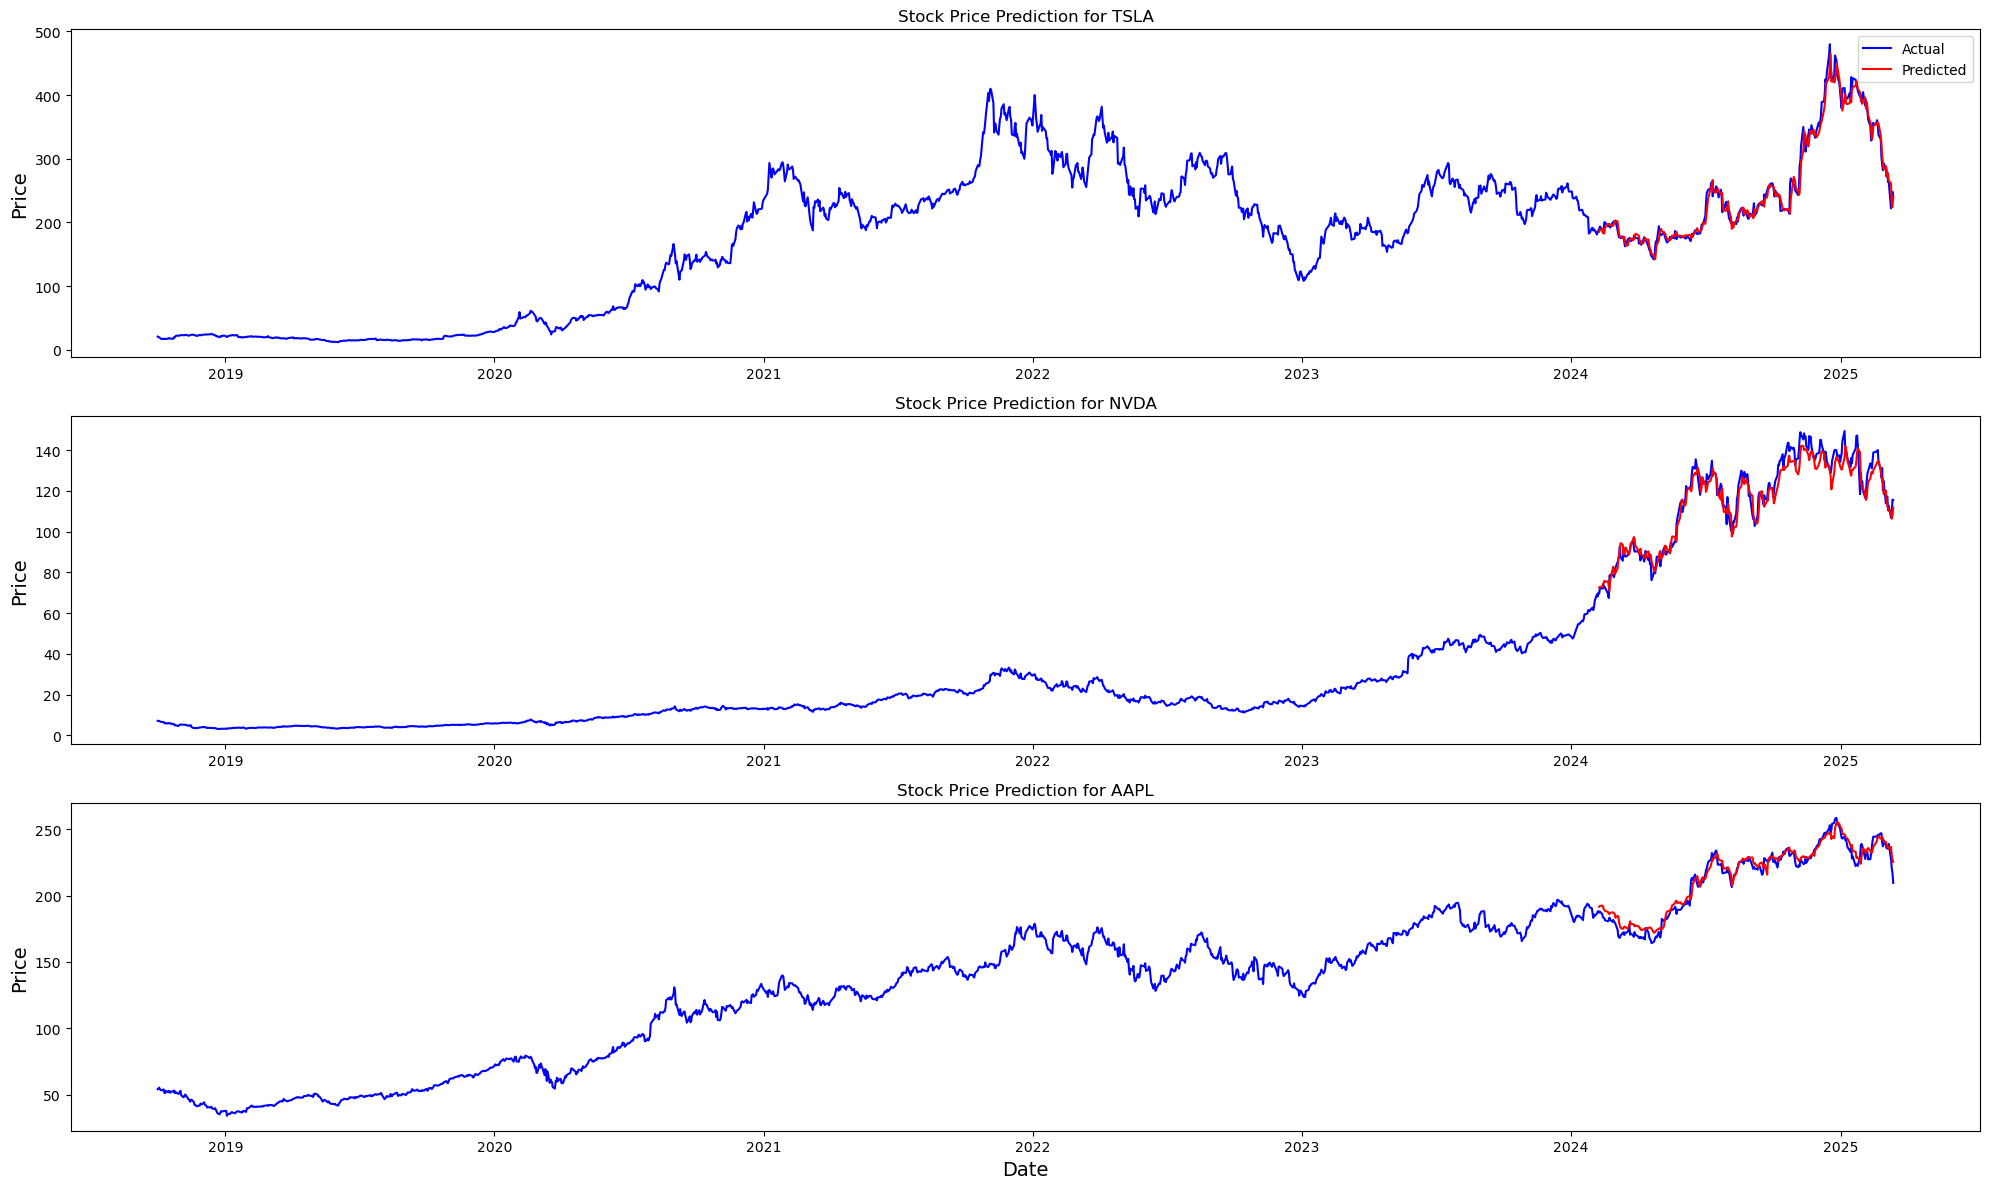

<Figure size 640x480 with 0 Axes>

In [16]:
plot_stock(['TSLA','NVDA','AAPL'],'2018-10-01')
plt.savefig('stock_plot.png')

<h5> And now we can see how it predicts the future

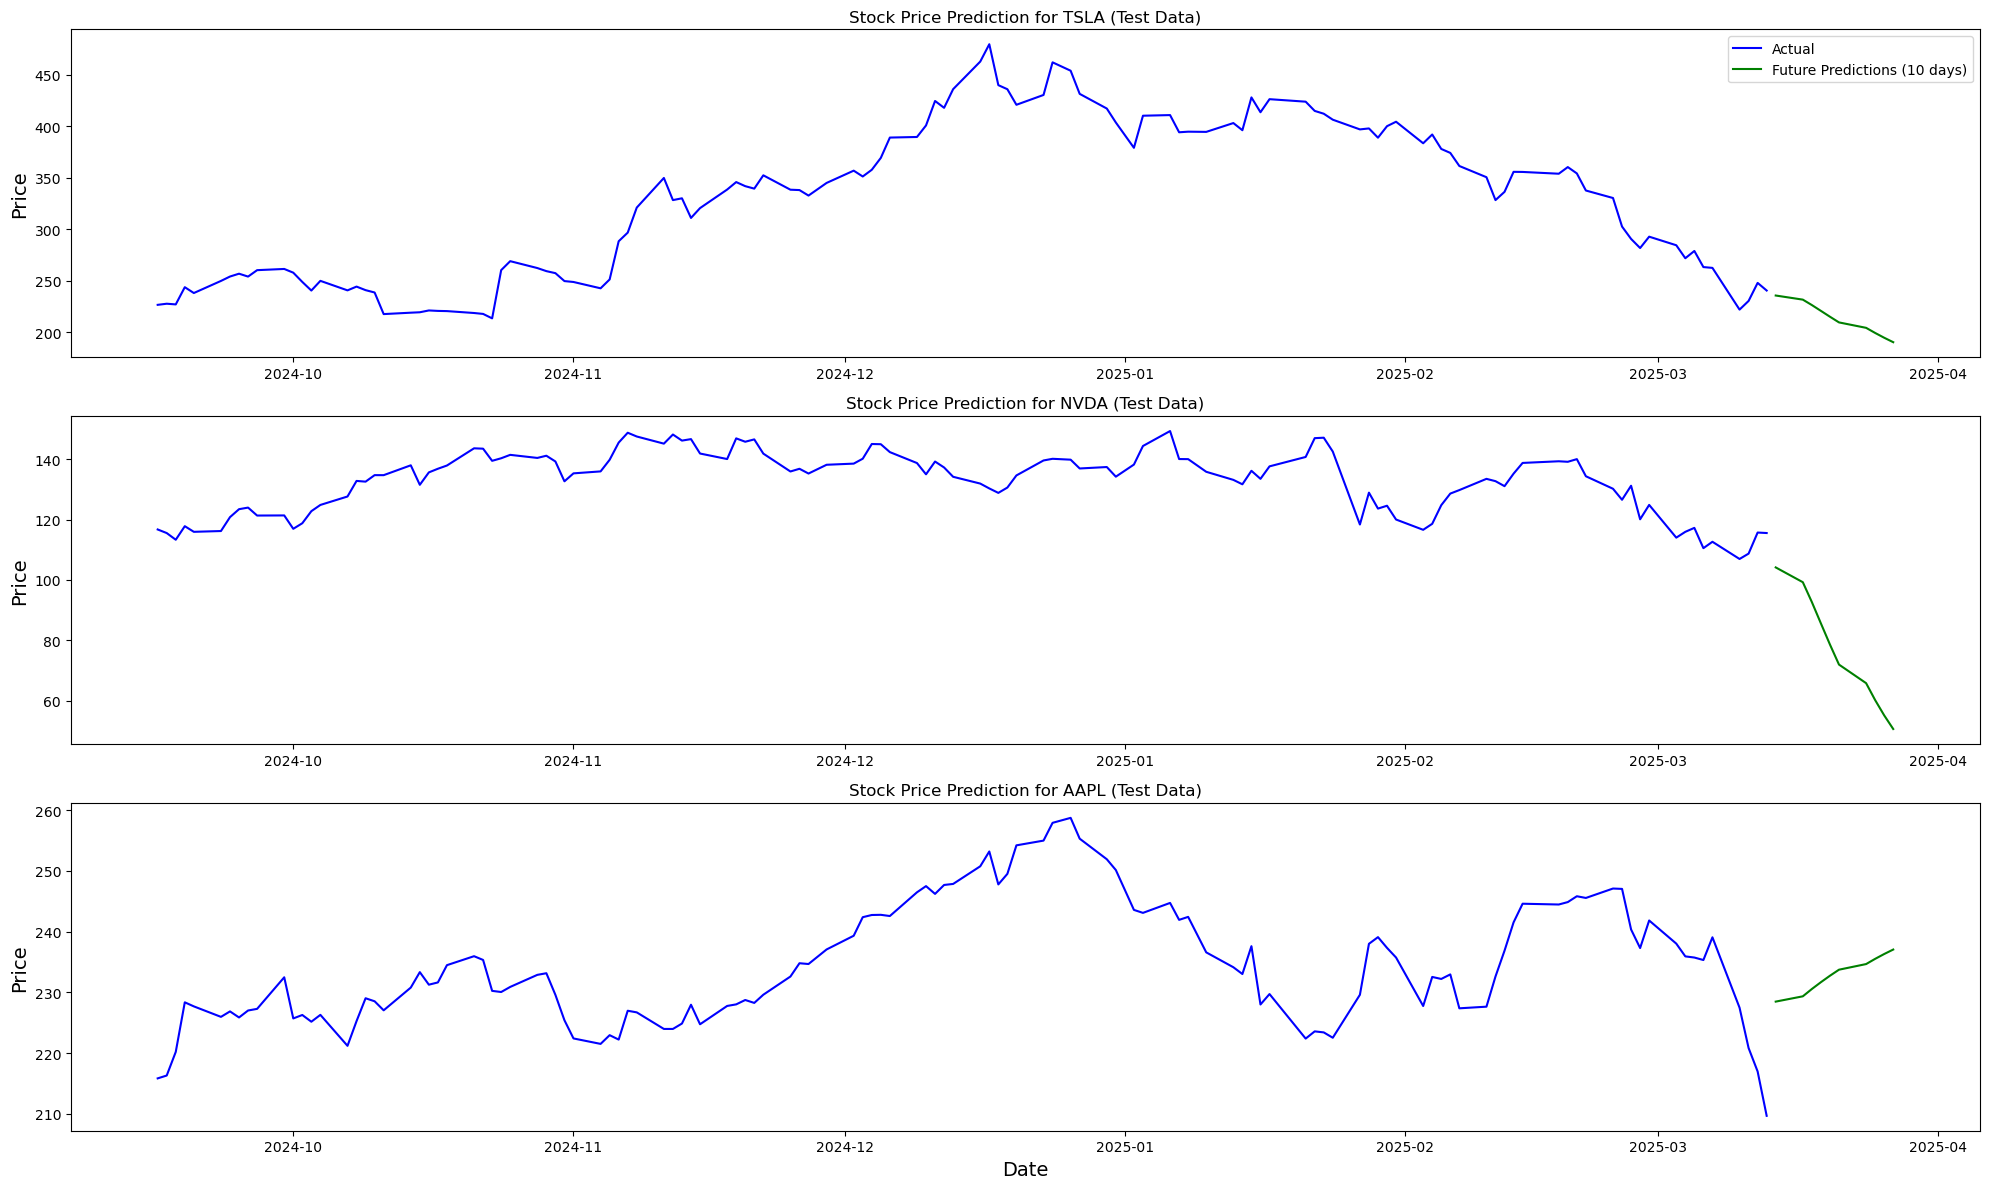

<Figure size 640x480 with 0 Axes>

In [20]:
plot_stock_with_future(['TSLA','NVDA','AAPL'], '2022-10-01',10)
plt.savefig('stock_plot_future.png')

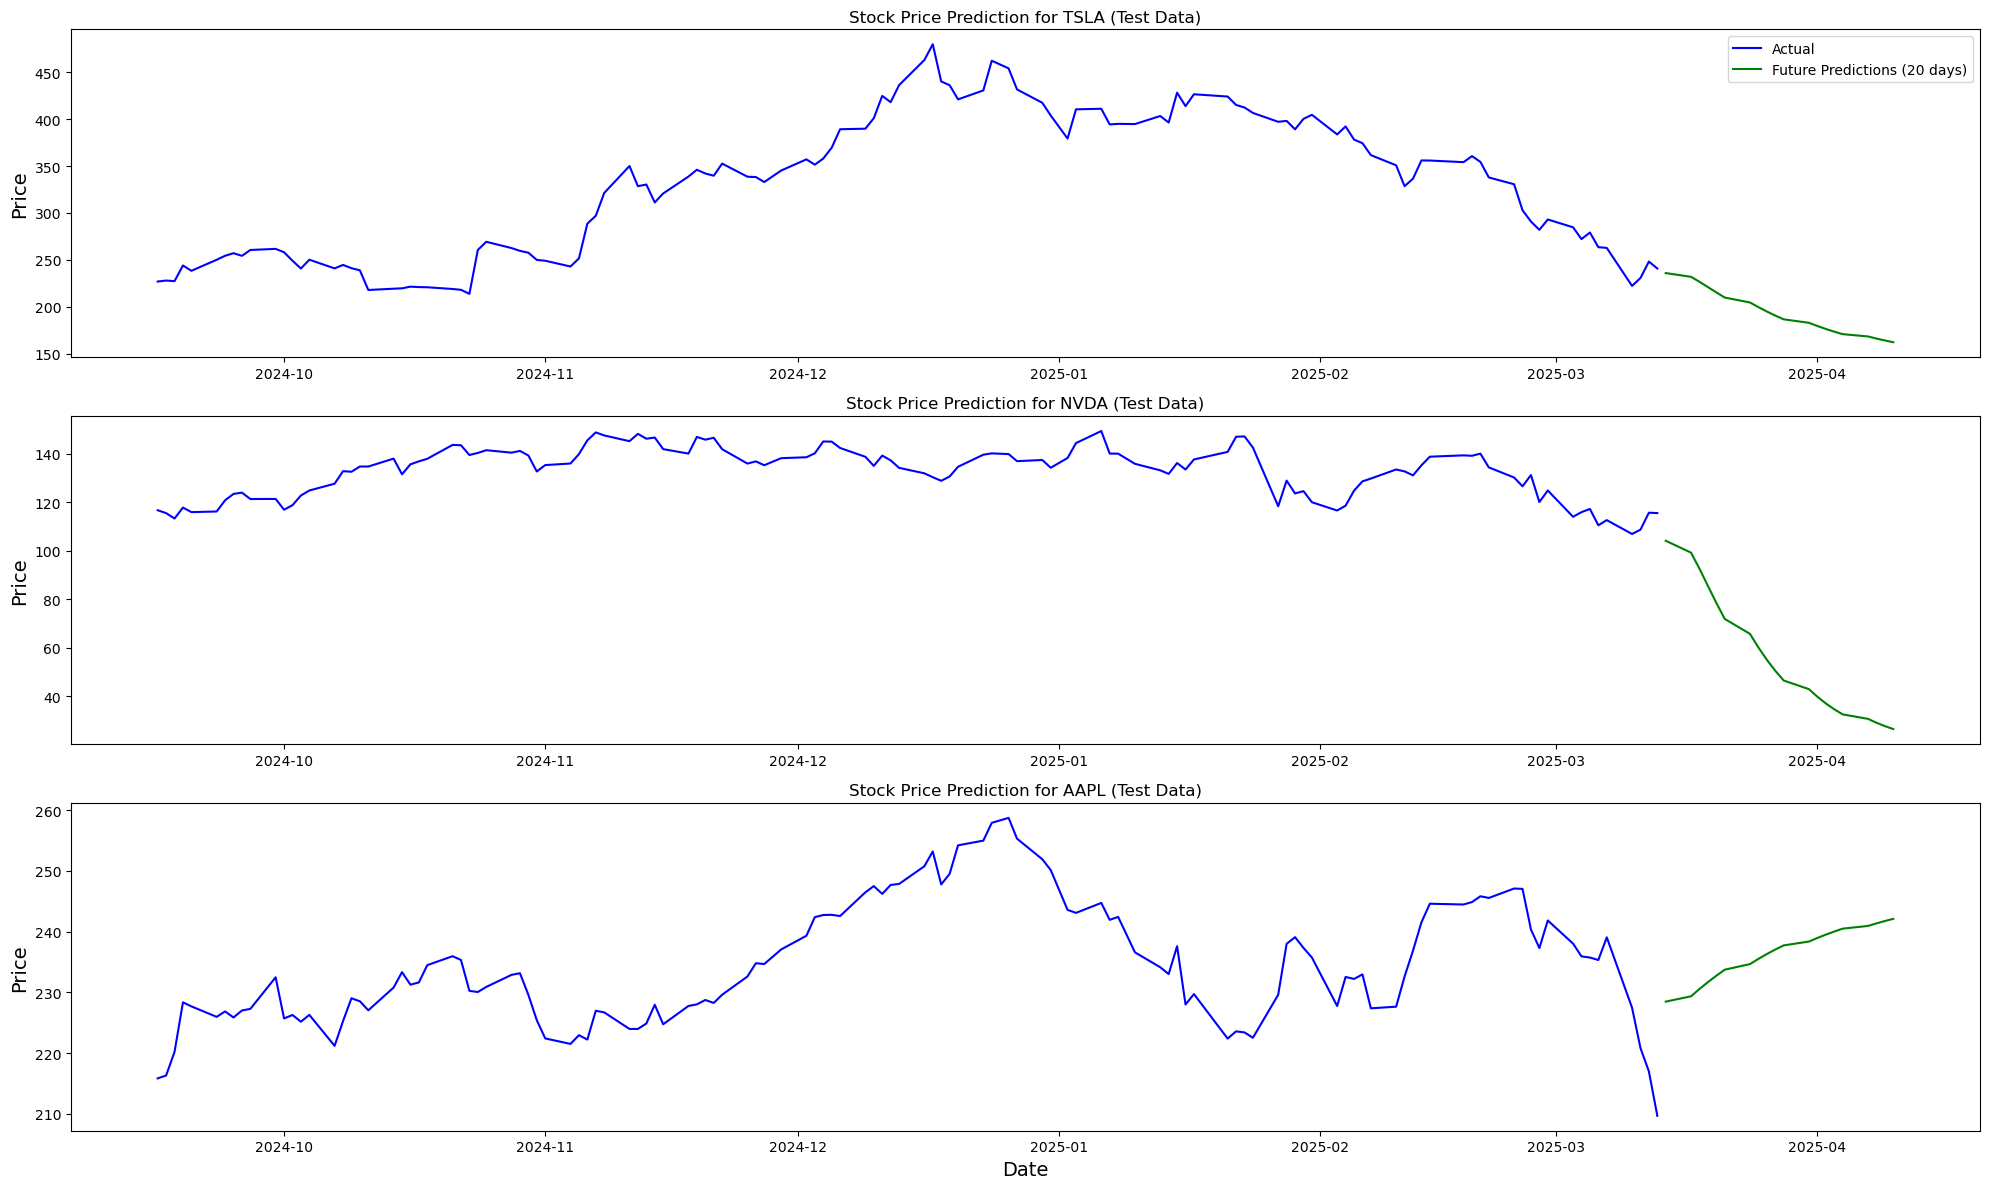

<Figure size 640x480 with 0 Axes>

In [19]:
plot_stock_with_future(['TSLA','NVDA','AAPL'], '2022-10-01',20)
plt.savefig('stock_plot_future_test.png')